# Face Generation
In this project, we use generative adversarial networks (GANs) to generate new images of faces.
### Get the Data
Using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '~/data'
# note: use full path on computer (not just ~)
data_dir = '/home/thojo/work/ud/deep-learning/face_generation/data'

import helper
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

In [2]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """


# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

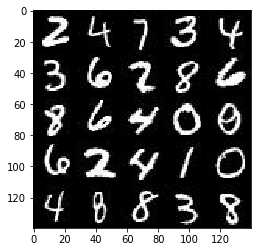

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

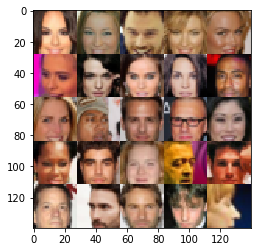

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim ):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2, keep_prob = 0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # done: implement function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 28x28x1 for MNIST and celebA
            
            x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer()) 
            # no batch_normalization in the first layer
            lrelu1 = tf.maximum( alpha*x1, x1)
            lrelu1 = tf.nn.dropout(lrelu1, keep_prob)
            # now 14x14x64

            x2 = tf.layers.conv2d(lrelu1, 128, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
            bn2 = tf.layers.batch_normalization( x2, training = True )
            lrelu2 = tf.maximum( alpha*bn2, bn2)
            lrelu2 = tf.nn.dropout(lrelu2, keep_prob)
            # now 7x7x128

            x3 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
            bn3 = tf.layers.batch_normalization( x3, training = True )
            lrelu3 = tf.maximum( alpha*bn3, bn3)
            lrelu3 = tf.nn.dropout(lrelu3, keep_prob)
            # now 4x4x256

            flat = tf.reshape( lrelu3,(-1,4*4*256) ) 
            logits = tf.layers.dense( flat, 1 )
            out = tf.sigmoid( logits )

            return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use the retry module or similar alternatives.
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
### This was my first generator.  Keeping it here for reference.  Please see next cell where I have added an extra layer.
# def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
#     """
#     Create the generator network
#     :param z: Input z
#     :param out_channel_dim: The number of channels in the output image
#     :param is_train: Boolean if generator is being used for training
#     :return: The tensor output of the generator
#     """
#     with tf.variable_scope("generator", reuse=not is_train):   
#         # Fully connected
#         x1 = tf.layers.dense(z, 2*2*256, kernel_initializer=tf.contrib.layers.xavier_initializer())
#         # Reshape first layer as 2x2x256
#         x1 = tf.reshape(x1, (-1, 2, 2, 256))
#         x1 = tf.layers.batch_normalization(x1, training=True)
#         x1 = tf.maximum( alpha*x1, x1) #leaky relu

#         # Second layer as (7x7x128)
#         x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID', kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
#         x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
#         # Third layer as (14x14x64)
#         x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum( alpha*x3, x3) #leaky relu

#         # Ouput layer as (28x28x out_channel_dim)
#         logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
#         out = tf.tanh(logits)

#     return out

# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# tests.test_generator(generator, tf)

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):   
        # Note: Based on reviewer's suggestion, adding an extra layer compared to the discriminator (4 vs 3) to make the generator stronger
        # Fully connected
        x1 = tf.layers.dense(z, 2*2*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape first layer as 2x2x512
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum( alpha*x1, x1) #leaky relu

        # Second layer as (4x4x256)
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
        # Second layer as (7x7x128)
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='VALID', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum( alpha*x3, x3) #leaky relu
        
        # Third layer as (14x14x64)
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum( alpha*x4, x4) #leaky relu

        # Ouput layer as (28x28x out_channel_dim)
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1 #For one-sided label smoothing (to prevent the discriminator from becoming too strong) 
    g_model = generator(input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real, reuse = False )
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1-smooth)*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, controlling dependencies approporiately
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode, print_every=100, show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1 )
 
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_num = 0
        for epoch_i in range(epoch_count):
            # Train Model
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 #rescaling to match the (-1,1) range of the tanh outputs from the generator
                steps += 1
                batch_num += 1
                # Sample random noise for G 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run( d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run( g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar })
                    train_loss_g = g_loss.eval({ input_z: batch_z, learning_rate: learning_rate_scalar})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch # {}/{}...".format(batch_num, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch # 100/1... Discriminator Loss: 1.1947... Generator Loss: 0.9227
Epoch 1/2... Batch # 200/1... Discriminator Loss: 1.1809... Generator Loss: 1.0192
Epoch 1/2... Batch # 300/1... Discriminator Loss: 1.2220... Generator Loss: 0.8972
Epoch 1/2... Batch # 400/1... Discriminator Loss: 1.2015... Generator Loss: 0.9676
Epoch 1/2... Batch # 500/1... Discriminator Loss: 1.1746... Generator Loss: 1.0044


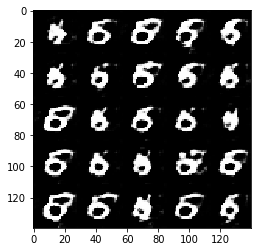

Epoch 1/2... Batch # 600/1... Discriminator Loss: 1.2341... Generator Loss: 0.8891
Epoch 1/2... Batch # 700/1... Discriminator Loss: 1.2896... Generator Loss: 0.7370
Epoch 1/2... Batch # 800/1... Discriminator Loss: 1.3317... Generator Loss: 1.0231
Epoch 1/2... Batch # 900/1... Discriminator Loss: 1.3585... Generator Loss: 0.7546
Epoch 1/2... Batch # 1000/1... Discriminator Loss: 1.3071... Generator Loss: 0.9441


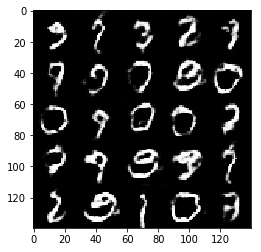

Epoch 1/2... Batch # 1100/1... Discriminator Loss: 1.2675... Generator Loss: 0.9844
Epoch 1/2... Batch # 1200/1... Discriminator Loss: 1.3502... Generator Loss: 0.8089
Epoch 1/2... Batch # 1300/1... Discriminator Loss: 1.3341... Generator Loss: 0.8674
Epoch 1/2... Batch # 1400/1... Discriminator Loss: 1.3162... Generator Loss: 0.7760
Epoch 1/2... Batch # 1500/1... Discriminator Loss: 1.2780... Generator Loss: 0.8788


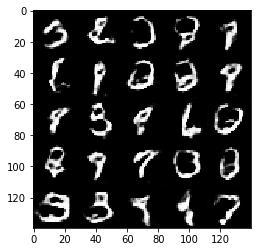

Epoch 1/2... Batch # 1600/1... Discriminator Loss: 1.3629... Generator Loss: 0.7616
Epoch 1/2... Batch # 1700/1... Discriminator Loss: 1.3263... Generator Loss: 0.7866
Epoch 1/2... Batch # 1800/1... Discriminator Loss: 1.3452... Generator Loss: 0.9324
Epoch 2/2... Batch # 1900/2... Discriminator Loss: 1.2766... Generator Loss: 0.8523
Epoch 2/2... Batch # 2000/2... Discriminator Loss: 1.3243... Generator Loss: 0.8591


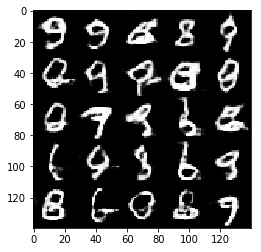

Epoch 2/2... Batch # 2100/2... Discriminator Loss: 1.3010... Generator Loss: 0.7647
Epoch 2/2... Batch # 2200/2... Discriminator Loss: 1.2820... Generator Loss: 0.8652
Epoch 2/2... Batch # 2300/2... Discriminator Loss: 1.2965... Generator Loss: 0.9476
Epoch 2/2... Batch # 2400/2... Discriminator Loss: 1.2818... Generator Loss: 0.8965
Epoch 2/2... Batch # 2500/2... Discriminator Loss: 1.2907... Generator Loss: 0.8181


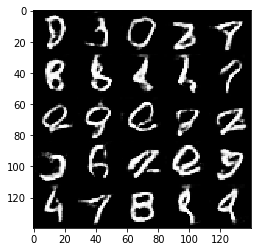

Epoch 2/2... Batch # 2600/2... Discriminator Loss: 1.3531... Generator Loss: 0.8310
Epoch 2/2... Batch # 2700/2... Discriminator Loss: 1.3274... Generator Loss: 0.9221
Epoch 2/2... Batch # 2800/2... Discriminator Loss: 1.3146... Generator Loss: 0.8970
Epoch 2/2... Batch # 2900/2... Discriminator Loss: 1.3127... Generator Loss: 0.8575
Epoch 2/2... Batch # 3000/2... Discriminator Loss: 1.3019... Generator Loss: 0.9795


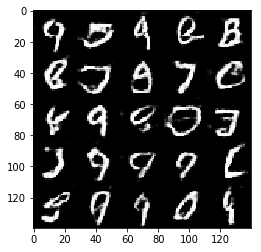

Epoch 2/2... Batch # 3100/2... Discriminator Loss: 1.2930... Generator Loss: 0.8014
Epoch 2/2... Batch # 3200/2... Discriminator Loss: 1.3587... Generator Loss: 1.0461
Epoch 2/2... Batch # 3300/2... Discriminator Loss: 1.3153... Generator Loss: 0.9248
Epoch 2/2... Batch # 3400/2... Discriminator Loss: 1.2913... Generator Loss: 0.8202
Epoch 2/2... Batch # 3500/2... Discriminator Loss: 1.3225... Generator Loss: 0.8131


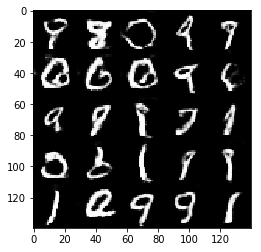

Epoch 2/2... Batch # 3600/2... Discriminator Loss: 1.3173... Generator Loss: 0.8661
Epoch 2/2... Batch # 3700/2... Discriminator Loss: 1.3103... Generator Loss: 0.8519


In [14]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode, print_every, show_every)

__Project notes for MNIST:__ With batch_size of 32, we can use slightly larger learning rates (0.0005) and get d_loss of 1.17 with g_loss of 0.76 (without dropout, Xavier init).   Whereas with batches of 16 and a learning rate of 0.0003, we only get to d_loss of 1.2883 and g_loss of 0.97. But these are training losses, so take with a pinch of salt.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch # 100/1... Discriminator Loss: 1.1327... Generator Loss: 0.9342
Epoch 1/1... Batch # 200/1... Discriminator Loss: 0.9369... Generator Loss: 1.0644
Epoch 1/1... Batch # 300/1... Discriminator Loss: 0.6897... Generator Loss: 1.9805
Epoch 1/1... Batch # 400/1... Discriminator Loss: 0.9060... Generator Loss: 1.4544
Epoch 1/1... Batch # 500/1... Discriminator Loss: 0.8025... Generator Loss: 1.2848


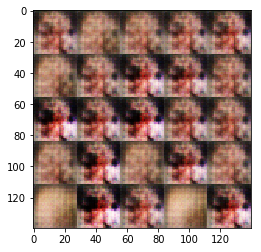

Epoch 1/1... Batch # 600/1... Discriminator Loss: 0.8596... Generator Loss: 1.4013
Epoch 1/1... Batch # 700/1... Discriminator Loss: 0.8548... Generator Loss: 1.3854
Epoch 1/1... Batch # 800/1... Discriminator Loss: 0.7269... Generator Loss: 1.6642
Epoch 1/1... Batch # 900/1... Discriminator Loss: 0.9399... Generator Loss: 1.2666
Epoch 1/1... Batch # 1000/1... Discriminator Loss: 0.7837... Generator Loss: 1.8886


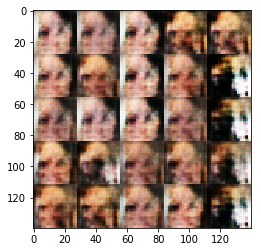

Epoch 1/1... Batch # 1100/1... Discriminator Loss: 0.7600... Generator Loss: 2.0837
Epoch 1/1... Batch # 1200/1... Discriminator Loss: 0.8813... Generator Loss: 1.3751
Epoch 1/1... Batch # 1300/1... Discriminator Loss: 4.8025... Generator Loss: 1.7401
Epoch 1/1... Batch # 1400/1... Discriminator Loss: 1.2221... Generator Loss: 1.1283
Epoch 1/1... Batch # 1500/1... Discriminator Loss: 1.0476... Generator Loss: 1.2587


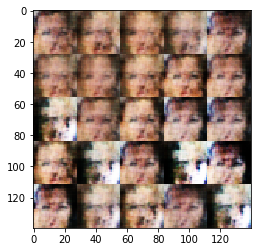

Epoch 1/1... Batch # 1600/1... Discriminator Loss: 1.1195... Generator Loss: 0.9608
Epoch 1/1... Batch # 1700/1... Discriminator Loss: 0.9667... Generator Loss: 1.5422
Epoch 1/1... Batch # 1800/1... Discriminator Loss: 1.2160... Generator Loss: 1.1494
Epoch 1/1... Batch # 1900/1... Discriminator Loss: 1.0655... Generator Loss: 1.3538
Epoch 1/1... Batch # 2000/1... Discriminator Loss: 1.1628... Generator Loss: 1.1949


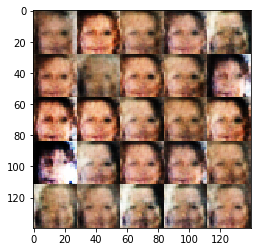

Epoch 1/1... Batch # 2100/1... Discriminator Loss: 1.4385... Generator Loss: 0.9930
Epoch 1/1... Batch # 2200/1... Discriminator Loss: 1.1373... Generator Loss: 0.9669
Epoch 1/1... Batch # 2300/1... Discriminator Loss: 1.1956... Generator Loss: 1.1960
Epoch 1/1... Batch # 2400/1... Discriminator Loss: 1.0690... Generator Loss: 1.0036
Epoch 1/1... Batch # 2500/1... Discriminator Loss: 1.2400... Generator Loss: 0.8987


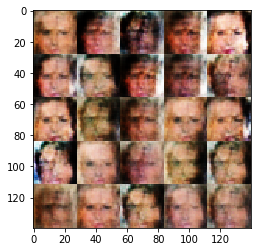

Epoch 1/1... Batch # 2600/1... Discriminator Loss: 1.1799... Generator Loss: 1.0229
Epoch 1/1... Batch # 2700/1... Discriminator Loss: 1.1940... Generator Loss: 1.0182
Epoch 1/1... Batch # 2800/1... Discriminator Loss: 1.0724... Generator Loss: 1.1554
Epoch 1/1... Batch # 2900/1... Discriminator Loss: 1.2633... Generator Loss: 0.9151
Epoch 1/1... Batch # 3000/1... Discriminator Loss: 1.1267... Generator Loss: 1.0381


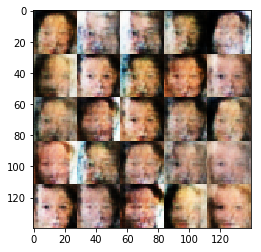

Epoch 1/1... Batch # 3100/1... Discriminator Loss: 1.1923... Generator Loss: 0.9249
Epoch 1/1... Batch # 3200/1... Discriminator Loss: 1.2031... Generator Loss: 1.5975
Epoch 1/1... Batch # 3300/1... Discriminator Loss: 1.1791... Generator Loss: 0.9580
Epoch 1/1... Batch # 3400/1... Discriminator Loss: 1.1355... Generator Loss: 1.1964
Epoch 1/1... Batch # 3500/1... Discriminator Loss: 1.1626... Generator Loss: 0.8917


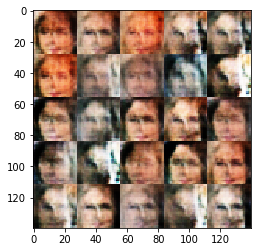

Epoch 1/1... Batch # 3600/1... Discriminator Loss: 1.0994... Generator Loss: 1.0530
Epoch 1/1... Batch # 3700/1... Discriminator Loss: 1.2359... Generator Loss: 0.9734
Epoch 1/1... Batch # 3800/1... Discriminator Loss: 1.1283... Generator Loss: 1.0175
Epoch 1/1... Batch # 3900/1... Discriminator Loss: 1.2369... Generator Loss: 0.9173
Epoch 1/1... Batch # 4000/1... Discriminator Loss: 1.2737... Generator Loss: 1.0639


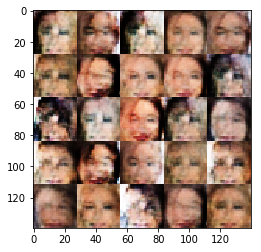

Epoch 1/1... Batch # 4100/1... Discriminator Loss: 1.2641... Generator Loss: 0.8815
Epoch 1/1... Batch # 4200/1... Discriminator Loss: 1.1943... Generator Loss: 1.0325
Epoch 1/1... Batch # 4300/1... Discriminator Loss: 1.2311... Generator Loss: 0.9757
Epoch 1/1... Batch # 4400/1... Discriminator Loss: 1.2700... Generator Loss: 0.9925
Epoch 1/1... Batch # 4500/1... Discriminator Loss: 1.3304... Generator Loss: 1.0185


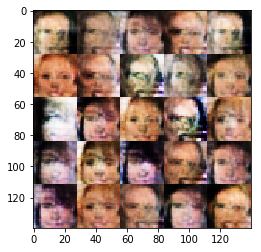

Epoch 1/1... Batch # 4600/1... Discriminator Loss: 1.2402... Generator Loss: 1.0531
Epoch 1/1... Batch # 4700/1... Discriminator Loss: 1.2378... Generator Loss: 0.8866
Epoch 1/1... Batch # 4800/1... Discriminator Loss: 1.3376... Generator Loss: 0.9871
Epoch 1/1... Batch # 4900/1... Discriminator Loss: 1.2770... Generator Loss: 1.0497
Epoch 1/1... Batch # 5000/1... Discriminator Loss: 1.2291... Generator Loss: 0.9165


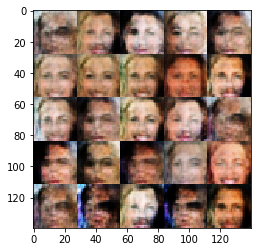

Epoch 1/1... Batch # 5100/1... Discriminator Loss: 1.1835... Generator Loss: 1.0370
Epoch 1/1... Batch # 5200/1... Discriminator Loss: 1.2732... Generator Loss: 1.2289
Epoch 1/1... Batch # 5300/1... Discriminator Loss: 1.2123... Generator Loss: 0.8989
Epoch 1/1... Batch # 5400/1... Discriminator Loss: 1.1448... Generator Loss: 0.9518
Epoch 1/1... Batch # 5500/1... Discriminator Loss: 1.1659... Generator Loss: 0.9683


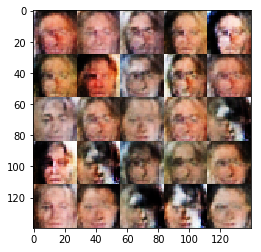

Epoch 1/1... Batch # 5600/1... Discriminator Loss: 1.2419... Generator Loss: 0.8871
Epoch 1/1... Batch # 5700/1... Discriminator Loss: 1.2465... Generator Loss: 0.8928
Epoch 1/1... Batch # 5800/1... Discriminator Loss: 1.2615... Generator Loss: 1.0350
Epoch 1/1... Batch # 5900/1... Discriminator Loss: 1.2009... Generator Loss: 1.0153
Epoch 1/1... Batch # 6000/1... Discriminator Loss: 1.2152... Generator Loss: 1.0645


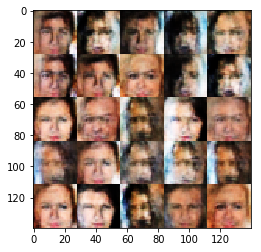

Epoch 1/1... Batch # 6100/1... Discriminator Loss: 1.1774... Generator Loss: 1.0043
Epoch 1/1... Batch # 6200/1... Discriminator Loss: 1.2886... Generator Loss: 0.9496
Epoch 1/1... Batch # 6300/1... Discriminator Loss: 1.2260... Generator Loss: 0.9517
Epoch 1/1... Batch # 6400/1... Discriminator Loss: 1.1765... Generator Loss: 0.9601
Epoch 1/1... Batch # 6500/1... Discriminator Loss: 1.1368... Generator Loss: 0.9242


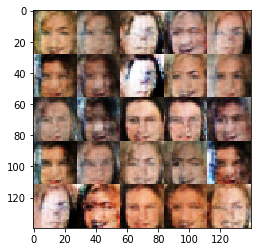

Epoch 1/1... Batch # 6600/1... Discriminator Loss: 1.2222... Generator Loss: 0.9416
Epoch 1/1... Batch # 6700/1... Discriminator Loss: 1.1989... Generator Loss: 0.9995
Epoch 1/1... Batch # 6800/1... Discriminator Loss: 1.2203... Generator Loss: 0.9064
Epoch 1/1... Batch # 6900/1... Discriminator Loss: 1.2837... Generator Loss: 0.8934
Epoch 1/1... Batch # 7000/1... Discriminator Loss: 1.2182... Generator Loss: 1.0265


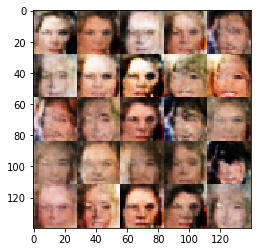

Epoch 1/1... Batch # 7100/1... Discriminator Loss: 1.1777... Generator Loss: 0.8922
Epoch 1/1... Batch # 7200/1... Discriminator Loss: 1.1982... Generator Loss: 0.9785
Epoch 1/1... Batch # 7300/1... Discriminator Loss: 1.2942... Generator Loss: 1.0424
Epoch 1/1... Batch # 7400/1... Discriminator Loss: 1.2349... Generator Loss: 1.0521
Epoch 1/1... Batch # 7500/1... Discriminator Loss: 1.1302... Generator Loss: 1.0756


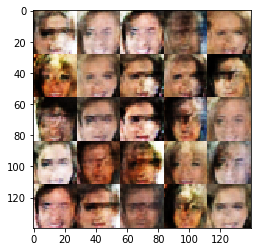

Epoch 1/1... Batch # 7600/1... Discriminator Loss: 1.1450... Generator Loss: 1.1128
Epoch 1/1... Batch # 7700/1... Discriminator Loss: 1.2206... Generator Loss: 0.8877
Epoch 1/1... Batch # 7800/1... Discriminator Loss: 1.1789... Generator Loss: 0.9776
Epoch 1/1... Batch # 7900/1... Discriminator Loss: 1.1677... Generator Loss: 1.0482
Epoch 1/1... Batch # 8000/1... Discriminator Loss: 1.2487... Generator Loss: 1.0479


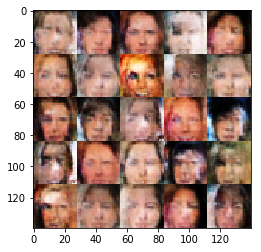

Epoch 1/1... Batch # 8100/1... Discriminator Loss: 1.1482... Generator Loss: 1.1822
Epoch 1/1... Batch # 8200/1... Discriminator Loss: 1.4546... Generator Loss: 0.7116
Epoch 1/1... Batch # 8300/1... Discriminator Loss: 1.4306... Generator Loss: 1.0263
Epoch 1/1... Batch # 8400/1... Discriminator Loss: 1.5434... Generator Loss: 0.9021
Epoch 1/1... Batch # 8500/1... Discriminator Loss: 1.4762... Generator Loss: 0.8832


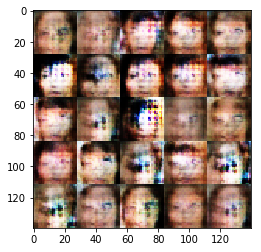

Epoch 1/1... Batch # 8600/1... Discriminator Loss: 1.4335... Generator Loss: 0.9046
Epoch 1/1... Batch # 8700/1... Discriminator Loss: 1.3465... Generator Loss: 0.7752
Epoch 1/1... Batch # 8800/1... Discriminator Loss: 1.3509... Generator Loss: 0.9173
Epoch 1/1... Batch # 8900/1... Discriminator Loss: 1.3915... Generator Loss: 0.8859
Epoch 1/1... Batch # 9000/1... Discriminator Loss: 1.4266... Generator Loss: 0.7887


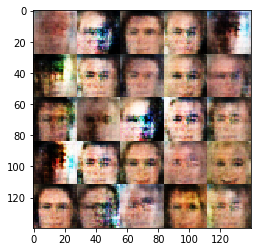

Epoch 1/1... Batch # 9100/1... Discriminator Loss: 1.4300... Generator Loss: 0.7939
Epoch 1/1... Batch # 9200/1... Discriminator Loss: 1.3694... Generator Loss: 0.9229
Epoch 1/1... Batch # 9300/1... Discriminator Loss: 1.3283... Generator Loss: 0.9678
Epoch 1/1... Batch # 9400/1... Discriminator Loss: 1.3962... Generator Loss: 0.8272
Epoch 1/1... Batch # 9500/1... Discriminator Loss: 1.4143... Generator Loss: 0.8224


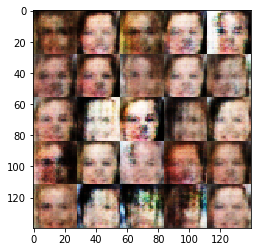

Epoch 1/1... Batch # 9600/1... Discriminator Loss: 1.3905... Generator Loss: 0.8139
Epoch 1/1... Batch # 9700/1... Discriminator Loss: 1.3922... Generator Loss: 0.8467
Epoch 1/1... Batch # 9800/1... Discriminator Loss: 1.3092... Generator Loss: 0.7634
Epoch 1/1... Batch # 9900/1... Discriminator Loss: 1.3901... Generator Loss: 0.8761
Epoch 1/1... Batch # 10000/1... Discriminator Loss: 1.4698... Generator Loss: 0.7451


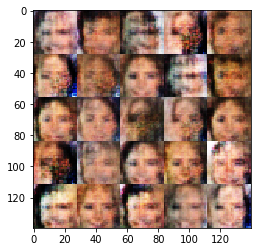

Epoch 1/1... Batch # 10100/1... Discriminator Loss: 1.4595... Generator Loss: 0.8824
Epoch 1/1... Batch # 10200/1... Discriminator Loss: 1.3448... Generator Loss: 0.8245
Epoch 1/1... Batch # 10300/1... Discriminator Loss: 1.4047... Generator Loss: 0.8647
Epoch 1/1... Batch # 10400/1... Discriminator Loss: 1.3686... Generator Loss: 0.8200
Epoch 1/1... Batch # 10500/1... Discriminator Loss: 1.3867... Generator Loss: 0.8479


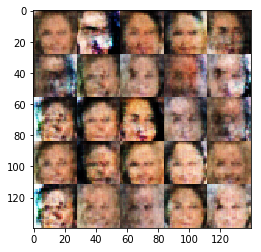

Epoch 1/1... Batch # 10600/1... Discriminator Loss: 1.3048... Generator Loss: 0.8578
Epoch 1/1... Batch # 10700/1... Discriminator Loss: 1.2903... Generator Loss: 0.8792
Epoch 1/1... Batch # 10800/1... Discriminator Loss: 1.3489... Generator Loss: 0.8038
Epoch 1/1... Batch # 10900/1... Discriminator Loss: 1.2959... Generator Loss: 0.7888
Epoch 1/1... Batch # 11000/1... Discriminator Loss: 1.2661... Generator Loss: 0.8702


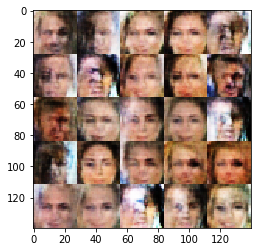

Epoch 1/1... Batch # 11100/1... Discriminator Loss: 1.2948... Generator Loss: 0.8609
Epoch 1/1... Batch # 11200/1... Discriminator Loss: 1.2381... Generator Loss: 0.8508
Epoch 1/1... Batch # 11300/1... Discriminator Loss: 1.2841... Generator Loss: 0.8547
Epoch 1/1... Batch # 11400/1... Discriminator Loss: 1.3226... Generator Loss: 0.9586
Epoch 1/1... Batch # 11500/1... Discriminator Loss: 1.4180... Generator Loss: 0.8341


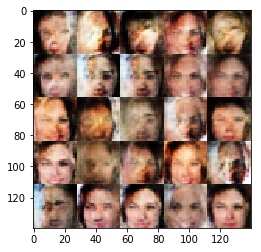

Epoch 1/1... Batch # 11600/1... Discriminator Loss: 1.3513... Generator Loss: 0.7402
Epoch 1/1... Batch # 11700/1... Discriminator Loss: 1.2878... Generator Loss: 0.8616
Epoch 1/1... Batch # 11800/1... Discriminator Loss: 1.2799... Generator Loss: 0.8292
Epoch 1/1... Batch # 11900/1... Discriminator Loss: 1.2962... Generator Loss: 0.9253
Epoch 1/1... Batch # 12000/1... Discriminator Loss: 1.2138... Generator Loss: 1.0057


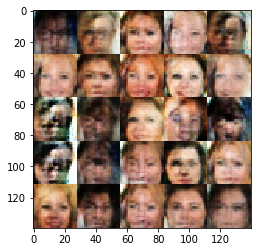

Epoch 1/1... Batch # 12100/1... Discriminator Loss: 1.2835... Generator Loss: 0.8148
Epoch 1/1... Batch # 12200/1... Discriminator Loss: 2.8818... Generator Loss: 0.9020
Epoch 1/1... Batch # 12300/1... Discriminator Loss: 1.2675... Generator Loss: 0.8550
Epoch 1/1... Batch # 12400/1... Discriminator Loss: 1.2802... Generator Loss: 0.8339
Epoch 1/1... Batch # 12500/1... Discriminator Loss: 1.2767... Generator Loss: 0.8951


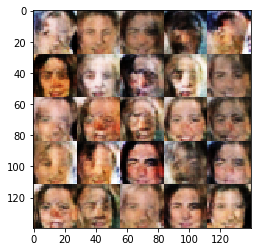

Epoch 1/1... Batch # 12600/1... Discriminator Loss: 1.6749... Generator Loss: 0.7131


In [15]:
batch_size = 16 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0003
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, print_every, show_every)

__Project notes:__ 

I have tried batch sizes of 16, 32, 64 and 128.  For smaller batches, the learning rate needs to be smaller too (as the gradients are more likely to go unstable).  Thanks to my reviewer for suggesting going as low as 16!

For learning rates, I went from 0.0002 to 0.0008.  Batch size 32 with a learning rate of 0.0005 seems to perform well for MNIST. However, for celebA, a smaller batch size (16), a smaller learning rate (0.0003) produces better images. d_loss was 1.34 and g_loss is 0.80.

Tried dropout.  For celebA, with batch_size = 16, lr=0.0002, dropout with keep_prob = 0.5 resulted in OK faces with d_loss=1.31 and g_loss =1.18. With keep_prob of 0.8, and a higher lr of 0.0003, we get to d_loss=1.35 and g_loss =0.80.  (32, 0.0003, 0.8) gives d-loss  = 1.17, g_loss =1.07

(16, 0.0003, 0.8) gives d-loss  = 1.67, g_loss = 0.71.  Despite the low generator loss, I find the figures not as good as the ones from before dropout, Xavier intialization and deeper generator were added. Will add dropout to generator as well. Also, I notice that while g_loss + d_loss is decreasing, each of these terms individually is not taking a steady path down.  I will cut the learning rate to see improvement in this regard.

I have also run this upto 50 epochs on AWS and that gave sharper and better outputs.  This is from the roughly 1 GB GPU that I have on my local machine.  For the project, we're looking at performance with just 1 epoch.  

Faces are recognizable in a single epoch.  I have tried beta1 values of 0.9, 0.5 and also lower values. 0.2 is good, as is 0.3.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.